# benchmark.
building a basic $E(3)$-equivariant message-passing graph neural network to predict internal energy at 0K on QM9 to make sure I am comfortable with this stuff in practice as well as in theory.

### import everything.
no PyTorch_Geometric. only vanilla PyTorch.

In [3]:
import math
from itertools import product
from typing import List, Any, Set
import random
import pandas as pd
import torch
from torch import Tensor, LongTensor
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### model components.  
the EVGNN has everything.  
EVMPLayer is message-passing.  
RowWiseFCL is just a FCL that operates on a tensor of an arbitrary row-length, since we want to be able to operate atom-wise on a molecule of an arbitrary number of atoms.  

In [12]:
class EVGNN1(nn.Module):
    def __init__(self) -> None:
        super(EVGNN1, self).__init__()
        # size of the embedding space
        self.embed_dim = 32
        
        self.embedding = nn.Embedding(118, self.embed_dim)
        self.mp1 = EVMPLayer(self.embed_dim)
        self.mp2 = EVMPLayer(self.embed_dim)
        self.prediction1 = RowWiseFCL(self.embed_dim, 8) 
        self.prediction2 = RowWiseFCL(8, 1) 

    def forward(self, data = Data) -> float:
        # print('IN MODEL\n', data)
        x = self.embedding(data.x.long())
        # print('EMBEDDING\n', x)
        x = self.mp1(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 1\n', x)
        x = self.mp2(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 2\n', x)
        x = self.prediction1(x)
        # print('PREDICTION 1\n', x)
        x = self.prediction2(x)
        # print('PREDICTION 2\n', x)
        U_hat = torch.sum(x)
        # print('FINAL PREDICTION\n', U_hat)
        return U_hat

In [13]:
class EVGNN2(nn.Module):
    def __init__(self) -> None:
        super(EVGNN2, self).__init__()
        # size of the embedding space
        self.embed_dim = 32
        
        self.embedding = nn.Embedding(118, self.embed_dim)
        self.mp1 = RestrictedEVMPLayer(self.embed_dim)
        self.mp2 = RestrictedEVMPLayer(self.embed_dim)
        self.prediction1 = RowWiseFCL(self.embed_dim, 8) 
        self.prediction2 = RowWiseFCL(8, 1) 

    def forward(self, data = Data) -> float:
        # print('IN MODEL\n', data)
        x = self.embedding(data.x.long())
        # print('EMBEDDING\n', x)
        x = self.mp1(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 1\n', x)
        x = self.mp2(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 2\n', x)
        x = self.prediction1(x)
        # print('PREDICTION 1\n', x)
        x = self.prediction2(x)
        # print('PREDICTION 2\n', x)
        U_hat = torch.sum(x)
        # print('FINAL PREDICTION\n', U_hat)
        return U_hat

In [14]:
class EVGNN3(nn.Module):
    def __init__(self) -> None:
        super(EVGNN3, self).__init__()
        # size of the embedding space
        self.embed_dim = 32
        
        self.embedding = nn.Embedding(118, self.embed_dim)
        self.mp1 = SquareEVMPLayer(self.embed_dim)
        self.mp2 = SquareEVMPLayer(self.embed_dim)
        self.prediction1 = RowWiseFCL(self.embed_dim, 8) 
        self.prediction2 = RowWiseFCL(8, 1) 

    def forward(self, data = Data) -> float:
        # print('IN MODEL\n', data)
        x = self.embedding(data.x.long())
        # print('EMBEDDING\n', x)
        x = self.mp1(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 1\n', x)
        x = self.mp2(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 2\n', x)
        x = self.prediction1(x)
        # print('PREDICTION 1\n', x)
        x = self.prediction2(x)
        # print('PREDICTION 2\n', x)
        U_hat = torch.sum(x)
        # print('FINAL PREDICTION\n', U_hat)
        return U_hat

In [15]:
class EVMPLayer(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super(EVMPLayer, self).__init__()
        self.embed_dim = embed_dim
        self.act = nn.Tanh()
        message_input_size = 2 * embed_dim + 1
        
        # take in a message tensor of size 2 * embed_dim + 1 and get out a new h_i of size embed_dim
        self.message_mlp = nn.Sequential(nn.Linear(message_input_size, embed_dim), self.act)
        
        # take in a message tensor of size embed_dim and an original h_i of size embed_dim and get out a new h_i of size embed_dim
        self.update_node_mlp = nn.Sequential(nn.Linear(2 * embed_dim, embed_dim), self.act)
                
    def make_message(self, source_tensor: int, target_tensor: int, distance: float) -> Tensor:
        combined_tensor = torch.cat((source_tensor.view(-1), target_tensor.view(-1), torch.Tensor([distance])))
        return self.message_mlp(combined_tensor)
    
    def update_node(self, node_tensor: Tensor, message_tensor: Tensor) -> Tensor:
        combined_tensor = torch.cat((node_tensor, message_tensor)).view(1,-1)
        return self.update_node_mlp(combined_tensor)
    
    def forward(self, embed_tensor: Tensor, edge_distances: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros_like(embed_tensor)
        # for each molecule in the dataset
        for ix, source in enumerate(embed_tensor):
            # create a tensor that tracks the sum of the messages
            message_sum = torch.zeros_like(source)
            # for each other molecule in the dataset
            for jx, target in enumerate(embed_tensor):
                if ix != jx:
                    # add the message tensor between them to the sum tensor
                    message_sum += self.make_message(source, target, edge_distances[ix,jx].item())
            # update the tensor that keeps track of all molecule embeddings by making its row ix the new embedding of the molecule
            new_embed_tensor[ix] = self.update_node(source, message_sum)
        
        return new_embed_tensor
            

In [16]:
class RestrictedEVMPLayer(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super(RestrictedEVMPLayer, self).__init__()
        self.embed_dim = embed_dim
        self.act = nn.Tanh()
        message_input_size = 2 * embed_dim + 1
        
        # take in a message tensor of size 2 * embed_dim + 1 and get out a new h_i of size embed_dim
        self.message_mlp = nn.Sequential(nn.Linear(message_input_size, embed_dim), self.act)
        
        # take in a message tensor of size embed_dim and an original h_i of size embed_dim and get out a new h_i of size embed_dim
        self.update_node_mlp = nn.Sequential(nn.Linear(2 * embed_dim, embed_dim), self.act)
                
    def make_message(self, source_tensor: int, target_tensor: int, distance: float) -> Tensor:
        combined_tensor = torch.cat((source_tensor.view(-1), target_tensor.view(-1), torch.Tensor([distance])))
        return self.message_mlp(combined_tensor)
    
    def update_node(self, node_tensor: Tensor, message_tensor: Tensor) -> Tensor:
        combined_tensor = torch.cat((node_tensor, message_tensor)).view(1,-1)
        return self.update_node_mlp(combined_tensor)
    
    def forward(self, embed_tensor: Tensor, edge_distances: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros_like(embed_tensor)
        # for each molecule in the dataset
        for ix, source in enumerate(embed_tensor):
            # create a tensor that tracks the sum of the messages
            message_sum = torch.zeros_like(source)
            # for each other molecule in the dataset
            for jx, target in enumerate(embed_tensor):
                if ix != jx:
                    # add the message tensor between them to the sum tensor
                    distance = edge_distances[ix,jx].item()
                    if distance < 2:
                        message_sum += self.make_message(source, target, distance)
            # update the tensor that keeps track of all molecule embeddings by making its row ix the new embedding of the molecule
            new_embed_tensor[ix] = self.update_node(source, message_sum)
        
        return new_embed_tensor
            

In [17]:
class SquareEVMPLayer(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super(SquareEVMPLayer, self).__init__()
        self.embed_dim = embed_dim
        self.act = nn.Tanh()
        message_input_size = 2 * embed_dim + 1
        
        # take in a message tensor of size 2 * embed_dim + 1 and get out a new h_i of size embed_dim
        self.message_mlp = nn.Sequential(nn.Linear(message_input_size, embed_dim), self.act)
        
        # take in a message tensor of size embed_dim and an original h_i of size embed_dim and get out a new h_i of size embed_dim
        self.update_node_mlp = nn.Sequential(nn.Linear(2 * embed_dim, embed_dim), self.act)
                
    def make_message(self, source_tensor: int, target_tensor: int, distance: float) -> Tensor:
        combined_tensor = torch.cat((source_tensor.view(-1), target_tensor.view(-1), torch.Tensor([distance])))
        return self.message_mlp(combined_tensor)
    
    def update_node(self, node_tensor: Tensor, message_tensor: Tensor) -> Tensor:
        combined_tensor = torch.cat((node_tensor, message_tensor)).view(1,-1)
        return self.update_node_mlp(combined_tensor)
    
    def forward(self, embed_tensor: Tensor, edge_distances: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros_like(embed_tensor)
        # for each molecule in the dataset
        for ix, source in enumerate(embed_tensor):
            # create a tensor that tracks the sum of the messages
            message_sum = torch.zeros_like(source)
            # for each other molecule in the dataset
            for jx, target in enumerate(embed_tensor):
                if ix != jx:
                    # add the message tensor between them to the sum tensor
                    distance = edge_distances[ix,jx].item()
                    message_sum += self.make_message(source, target, distance**2)
            # update the tensor that keeps track of all molecule embeddings by making its row ix the new embedding of the molecule
            new_embed_tensor[ix] = self.update_node(source, message_sum)
        
        return new_embed_tensor
            

In [18]:
class RowWiseFCL(nn.Module): 
    def __init__(self, in_dim: int, out_dim: int) -> None: 
        super(RowWiseFCL, self).__init__() 
        self.out_dim = out_dim
        self.row_layer = nn.Sequential(nn.Linear(in_dim, out_dim), nn.Tanh())
      
    def forward(self, embed_tensor: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros(embed_tensor.size(0), self.out_dim)
        for ix, row in enumerate(embed_tensor):
            new_embed_tensor[ix] = self.row_layer(row)
        return new_embed_tensor

### MoleculesDataset class.  
pretty stupid. just a wrapper for Data objects. the point was to be able to pass this into a DataLoader, but the PyTorch_Geometric DataLoader seems more trouble than it's worth, so as mentioned above, this will probably be deprecated soon.

In [19]:
class MoleculesDataset(Dataset):
    def __init__(self, data: List[Data]) -> None:
        super().__init__()
        self.data = data
        
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Data:
        return self.data[idx]

### Graph class.
the PyTorch Data objects are really bothering me, so I'm making my own version of them.

In [20]:
class FullyConnectedData():
    def __init__(self, x: Tensor, pos: Tensor, y: Tensor) -> None:
        self.x = x
        self.pos = pos
        self.y = y
        self.e = make_edge_distances(pos)
        
    def __len__(self) -> int:
        return x.size(0)
    
    def __str__(self):
        return f"x: {self.x.size()} | pos: {self.pos.size()} | e: {self.e.size()} | y = {self.y}"

In [21]:
class Data():
    def __init__(self, x: Tensor, pos: Tensor, connectivity: List[Set[int]], y: Tensor) -> None:
        self.x = x
        self.pos = pos
        self.y = y
        self.e = torch.zeros(x.size(0), x.size(0))
        self.connectivity = connectivity
        for pair in connectivity:
            a, b = pair
            self.e[a][b] = self.e[b][a] = compute_distance(pos[a], pos[b])
        
    def __len__(self) -> int:
        return x.size(0)
    
    def __str__(self):
        return f"x: {self.x.size()} | pos: {self.pos.size()} | e: {self.e.size()} | y = {self.y}"

### helper functions.
all self-explanitory. makes it simpler to build the Data items.

In [22]:
def compute_distance(pos1: Tensor, pos2: Tensor) -> float:
    return torch.sum(torch.pow(torch.sub(pos1, pos2), 2)).item()

In [23]:
def make_edge_distances(positions: Tensor) -> Tensor:
    edge_distances = torch.zeros(positions.size(0), positions.size(0))
    for ix, source_position in enumerate(positions):
        for jx, target_position in enumerate(positions):
            edge_distances[ix][jx] = compute_distance(source_position, target_position)
    return edge_distances

### build model and run it.

In [24]:
lr = 0.01
batch_size = 32
fcle = EVGNN1()
optim = torch.optim.Adam(fcle.parameters(), lr=lr)
loss_fn = nn.MSELoss()
fcle_losses = []

fcle.train()
for i in range(24):
    train_dataset = torch.load(f'Zebra/T{i}.pt')

    loss = torch.Tensor([0])
    loss.requires_grad = True

    j = 0
    for data in train_dataset:
        U_hat = fcle(data)
        U = data.y
        loss = torch.add(loss,loss_fn(U_hat, U))
        
        j += 1
        if j % batch_size == 0 or j == len(train_dataset)-1:
            optim.zero_grad()
            loss.backward()
            optim.step()
            fcle_losses.append(loss.item())
            loss = torch.Tensor([0])
            loss.requires_grad = True

            print(f'DATA TRANCHE {i} | {j} EXAMPLES COMPLETE | PRIOR BATCH LOSS {fcle_losses[-1]}')
            
torch.save(fcle,'Zebra/fcle.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'Zebra/T0.pt'

In [ ]:
lr = 0.01
batch_size = 32
pcle = EVGNN2()
optim = torch.optim.Adam(pcle.parameters(), lr=lr)
loss_fn = nn.MSELoss()
pcle_losses = []

pcle.train()
for i in range(24):
    train_dataset = torch.load(f'Zebra/T{i}.pt')

    loss = torch.Tensor([0])
    loss.requires_grad = True

    j = 0
    for data in train_dataset:
        U_hat = pcle(data)
        U = data.y
        loss = torch.add(loss,loss_fn(U_hat, U))
        
        j += 1
        if j % batch_size == 0 or j == len(train_dataset)-1:
            optim.zero_grad()
            loss.backward()
            optim.step()
            pcle_losses.append(loss.item())
            loss = torch.Tensor([0])
            loss.requires_grad = True

            print(f'DATA TRANCHE {i} | {j} EXAMPLES COMPLETE | PRIOR BATCH LOSS {pcle_losses[-1]}')
            
torch.save(pcle,'Zebra/pcle.pt')

In [ ]:
lr = 0.01
batch_size = 32
fcse = EVGNN3()
optim = torch.optim.Adam(fcse.parameters(), lr=lr)
loss_fn = nn.MSELoss()
fcse_losses = []

fcse.train()
for i in range(24):
    train_dataset = torch.load(f'Zebra/T{i}.pt')

    loss = torch.Tensor([0])
    loss.requires_grad = True

    j = 0
    for data in train_dataset:
        U_hat = fcse(data)
        U = data.y
        loss = torch.add(loss,loss_fn(U_hat, U))
        
        j += 1
        if j % batch_size == 0 or j == len(train_dataset)-1:
            optim.zero_grad()
            loss.backward()
            optim.step()
            fcse_losses.append(loss.item())
            loss = torch.Tensor([0])
            loss.requires_grad = True

            print(f'DATA TRANCHE {i} | {j} EXAMPLES COMPLETE | PRIOR BATCH LOSS {fcse_losses[-1]}')
            
torch.save(fcse,'Zebra/fcse.pt')

In [ ]:
xs = [x for x in range(len(pcle_losses))]

# plt.plot(xs, losses)
plt.plot(xs, fcse_losses, "blue")
plt.plot(xs, fcle_losses, "red")
plt.plot(xs, pcle_losses, "green")
plt.yscale('log',base=2)
plt.show()
plt.close()

In [25]:
fcle = torch.load('Zebra/models/fcle.pt')
fcse = torch.load('Zebra/models/fcse.pt')
pcle = torch.load('Zebra/models/pcle.pt')

models = [fcle, fcse, pcle]

In [26]:
for model in models:
    model.eval()

In [29]:
fcle_losses = []
fcse_losses = []
pcle_losses = []
loss_fn = nn.MSELoss()

i = 0
with torch.no_grad():
    for i in range(2):
        test_dataset = torch.load(f'Zebra/data/E{i}.pt')
        for data in test_dataset:
            i+=1
            if i % 100 == 0:
                print(f'TESTING ON MOLECULE {i}')
                print(f'MOST RECENT LOSSES: {fcle_losses[-1]}, {fcse_losses[-1]}, {pcle_losses[-1]}')
            U = data.y
            fcle_losses.append(loss_fn(models[0](data),U).item())
            fcse_losses.append(loss_fn(models[1](data),U).item())
            pcle_losses.append(loss_fn(models[2](data),U).item())

torch.save(Tensor(fcle_losses),'Zebra/losses/fcle_losses.pt')
torch.save(Tensor(fcse_losses),'Zebra/losses/fcse_losses.pt')
torch.save(Tensor(pcle_losses),'Zebra/losses/pcle_losses.pt')

TESTING ON MOLECULE 100
MOST RECENT LOSSES: 0.002475201850757003, 0.003345774719491601, 2.2635164498296945e-07
TESTING ON MOLECULE 200
MOST RECENT LOSSES: 0.004341156221926212, 0.004435873124748468, 1.6145830159075558e-05
TESTING ON MOLECULE 300
MOST RECENT LOSSES: 0.016295183449983597, 0.01611316204071045, 1.769265054463176e-06
TESTING ON MOLECULE 400
MOST RECENT LOSSES: 0.0019733591470867395, 0.0019103550584986806, 2.2825133783044294e-06
TESTING ON MOLECULE 500
MOST RECENT LOSSES: 1.3769536053587217e-06, 1.8916853150585666e-07, 0.00020535316434688866
TESTING ON MOLECULE 600
MOST RECENT LOSSES: 1.28455553749518e-06, 2.255583240184933e-07, 1.0423888852528762e-05
TESTING ON MOLECULE 700
MOST RECENT LOSSES: 0.012863611802458763, 0.013409769162535667, 2.2281517885858193e-05
TESTING ON MOLECULE 800
MOST RECENT LOSSES: 0.02130255661904812, 0.021684158593416214, 5.938656613579951e-06
TESTING ON MOLECULE 900
MOST RECENT LOSSES: 1.5961290955601726e-06, 1.1897813578798377e-07, 6.595280137844384

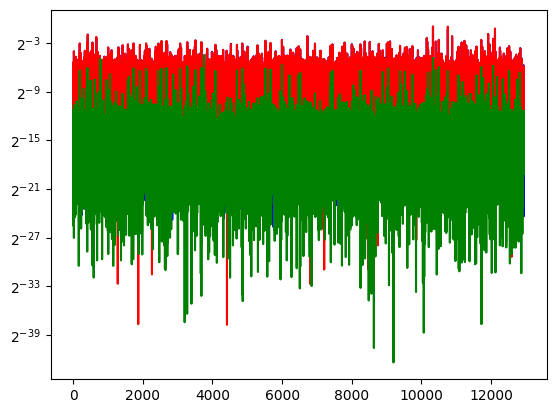

In [37]:
fcle_losses_tensor = Tensor(fcle_losses)
fcse_losses_tensor = Tensor(fcse_losses)
pcle_losses_tensor = Tensor(pcle_losses)

fcle_losses_tensor = torch.sqrt(fcle_losses_tensor)
fcse_losses_tensor = torch.sqrt(fcse_losses_tensor)
pcle_losses_tensor = torch.sqrt(pcle_losses_tensor)

fcle_mae = torch.mean(fcle_losses_tensor).item() * -13388.7246
fcse_mae = torch.mean(fcse_losses_tensor).item() * -13388.7246
pcle_mae = torch.mean(pcle_losses_tensor).item() * -13388.7246

In [38]:
print(fcle_mae, fcse_mae, pcle_mae)

-955.3236168444022 -961.8033225941688 -85.67804070188217


In [44]:
graph_features_df = pd.read_csv('og_data/original_QM9/Y.txt', header=None)
graph_features = torch.tensor(graph_features_df.values)
del graph_features_df
internal_energies = graph_features[:,7]

print(torch.std(internal_energies))

tensor(1086.5428, dtype=torch.float64)
